# Uber Pickup Forecast

In [2]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime
import time
import seaborn as sns
import os
import math
import xgboost as xgb
import matplotlib
matplotlib.use('nbagg')
import sklearn

import warnings
warnings.simplefilter('ignore')

In [136]:
apr_2014 = pd.read_csv("Desktop\\Taxi Demand\\uber-raw-data-apr14.csv")
apr_2014.columns = [c.replace(" ", "") for c in apr_2014.columns] 
may_2014 = pd.read_csv("Desktop\\Taxi Demand\\uber-raw-data-may14.csv")
may_2014.columns = [c.replace(" ", "") for c in may_2014.columns] 

In [137]:
data_2014=pd.concat([apr_2014, may_2014], ignore_index=True)

In [138]:
data_2014

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
1216946,5/31/2014 23:45:00,40.7309,-74.0014,B02764
1216947,5/31/2014 23:52:00,40.7528,-73.9798,B02764
1216948,5/31/2014 23:55:00,40.7158,-73.9519,B02764
1216949,5/31/2014 23:56:00,40.6961,-73.8997,B02764


In [139]:
data_2014 = data_2014[(((data_2014.Lat >= 40.5774) & (data_2014.Lat <= 40.9176)) & ((data_2014.Lon >= -74.15) & (data_2014.Lon <= -73.7004)))]

In [140]:
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

pickups_within_NYC = data_2014.sample(n = 500)

for i,j in pickups_within_NYC.iterrows():
    folium.Marker([j["Lat"], j["Lon"]]).add_to(m)
m

In [141]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans

In [142]:
coord = data_2014[["Lat", "Lon"]].values
neighbors = []

def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                #you can check the documentation of above "gpxpy.geo.haversine_distance" at "https://github.com/tkrajina/gpxpy/blob/master/gpxpy/geo.py"
                #"gpxpy.geo.haversine_distance" gives distance between two latitudes and longitudes in meters. So, we have to convert it into miles.
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [143]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 1.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 8.0
Minimum distance between any two clusters = 0.8758650806086837
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 18.0
Minimum distance between any two clusters = 0.8611088896863179
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 3.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 27.0
Minimum distance between any two clusters = 0.5912914610797564
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 4.0
Avg. Number clusters outside of vicinity where inte

In [144]:
coord = data_2014[["Lat", "Lon"]].values
regions = MiniBatchKMeans(n_clusters = 50, batch_size = 10000, random_state=0).fit(coord)
data_2014["region_cluster"] = regions.predict(data_2014[["Lat", "Lon"]])
data_2014["cl_centers"]=

In [145]:
data_2014.head()

,Date/Time,Lat,Lon,Base,region_cluster
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,11
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,26
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,29
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,5
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,39


<IPython.core.display.Javascript object>


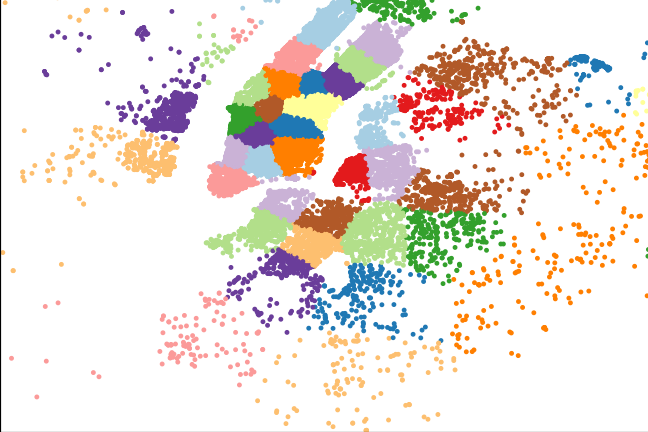

In [146]:
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = data_2014.Lon.values[:70000], y = data_2014.Lat.values[:70000], c = data_2014.region_cluster.values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [147]:
data_2014["Date"]=pd.to_datetime(data_2014["Date/Time"]).dt.strftime('%Y-%m-%d-%H')
data_2014

,Date/Time,Lat,Lon,Base,region_cluster,Date
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,11,2014-04-01-00
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,26,2014-04-01-00
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,29,2014-04-01-00
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,5,2014-04-01-00
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,39,2014-04-01-00
...,...,...,...,...,...,...
1216946,5/31/2014 23:45:00,40.7309,-74.0014,B02764,37,2014-05-31-23
1216947,5/31/2014 23:52:00,40.7528,-73.9798,B02764,41,2014-05-31-23
1216948,5/31/2014 23:55:00,40.7158,-73.9519,B02764,34,2014-05-31-23
1216949,5/31/2014 23:56:00,40.6961,-73.8997,B02764,46,2014-05-31-23


In [148]:
count=data_2014.groupby(["Date", "region_cluster"])["region_cluster"].count()
# count=data_2014.groupby('Date')['region_cluster'].count()
count

Date           region_cluster
2014-04-01-00  0                  2
               1                  5
               2                  5
               4                  2
               5                 11
                                 ..
2014-05-31-23  45                37
               46                35
               47                 8
               48                 4
               49                29
Name: region_cluster, Length: 64945, dtype: int64

In [149]:
data_2014_new=data_2014.groupby(['Date','region_cluster']).size().reset_index(name='count')
data_2014_new

,Date,region_cluster,count
0,2014-04-01-00,0,2
1,2014-04-01-00,1,5
2,2014-04-01-00,2,5
3,2014-04-01-00,4,2
4,2014-04-01-00,5,11
...,...,...,...
64940,2014-05-31-23,45,37
64941,2014-05-31-23,46,35
64942,2014-05-31-23,47,8
64943,2014-05-31-23,48,4


In [150]:
date=pd.to_datetime(data_2014_new['Date'], format='%Y-%m-%d-%H')
data_2014_new['Month']=date.dt.month
data_2014_new['Day']=date.dt.day
data_2014_new['Hour']=date.dt.hour
temp=pd.DatetimeIndex(date)
data_2014_new['Weekday']=temp.weekday
data_2014_new

,Date,region_cluster,count,Month,Day,Hour,Weekday
0,2014-04-01-00,0,2,4,1,0,1
1,2014-04-01-00,1,5,4,1,0,1
2,2014-04-01-00,2,5,4,1,0,1
3,2014-04-01-00,4,2,4,1,0,1
4,2014-04-01-00,5,11,4,1,0,1
...,...,...,...,...,...,...,...
64940,2014-05-31-23,45,37,5,31,23,5
64941,2014-05-31-23,46,35,5,31,23,5
64942,2014-05-31-23,47,8,5,31,23,5
64943,2014-05-31-23,48,4,5,31,23,5


In [151]:
data_model=data_2014_new[['Month','Weekday', 'Hour', 'Day','region_cluster','count']]
data_model

,Month,Weekday,Hour,Day,region_cluster,count
0,4,1,0,1,0,2
1,4,1,0,1,1,5
2,4,1,0,1,2,5
3,4,1,0,1,4,2
4,4,1,0,1,5,11
...,...,...,...,...,...,...
64940,5,5,23,31,45,37
64941,5,5,23,31,46,35
64942,5,5,23,31,47,8
64943,5,5,23,31,48,4


In [152]:
# import statsmodels.api as sm
add_dummies = pd.get_dummies(data_model['region_cluster'])
data_model = pd.concat([data_model, add_dummies], axis=1)
data_model.drop(['region_cluster'], inplace=True, axis=1)
target=data_model[['count']]
data=data_model[[col for col in data_model.columns if col not in ['count']]]

In [153]:
data

,Month,Weekday,Hour,Day,0,1,2,3,4,5,...,40,41,42,43,44,45,46,47,48,49
0,4,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64940,5,5,23,31,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
64941,5,5,23,31,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
64942,5,5,23,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
64943,5,5,23,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [154]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)
from scipy import stats
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Random forest

In [181]:
RFR=RandomForestRegressor()
RFR

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [182]:
RFR.fit(x_train, y_train)
print(r2_score(y_train,RFR.predict(x_train)))
s1=r2_score(y_test,RFR.predict(x_test))
s1

0.9861415311529106


0.8949024669717446

### XgBoost 

In [183]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Various hyper-parameters to tune
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  24 out of  24 | elapsed:  2.1min finished


0.8922005289271895
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [184]:
XGB=xgb.XGBRegressor(colsample_bytree=0.7, learning_rate= 0.07, max_depth= 8, min_child_weight= 4, n_estimators= 500, nthread=4, silent= True, subsample= 0.7)

XGB.fit(x_train, y_train)
print(r2_score(y_train, XGB.predict(x_train)))
s2=r2_score(y_test, XGB.predict(x_test))
s2

0.9489803706722502


0.9082223541330653

### Gradient Boosting

In [186]:
from sklearn import ensemble
xbr=ensemble.GradientBoostingRegressor(alpha=0.92,max_depth=8)
xbr

GradientBoostingRegressor(alpha=0.92, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [187]:
xbr.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.92, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [188]:
print(r2_score(y_train, xbr.predict(x_train)))
s3=r2_score(y_test, xbr.predict(x_test))
s3

0.9048421604029172


0.8621897373904623

In [189]:
data = [['Random Forest', s1], ['XgBoost', s2], ['Gradient Boosting', s3]] 

In [190]:
df = pd.DataFrame(data, columns = ['ML model', 'Accuracy']) 
df

,ML model,Accuracy
0,Random Forest,0.894902
1,XgBoost,0.908222
2,Gradient Boosting,0.862190
